In [1]:
import numpy as np 
import pandas as pd 
import pickle

from FDSSC import models, utils
from datasets.datasets import LocationChecker, FDSSCDataset, RandomRotation
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader

In [2]:
datadir = "data/stacked_images"
labeldir = "siteData/mixedData/"
normdir = "siteData/allData/"
cachedir = "data/cached_images"
checker = LocationChecker(datadir, size=(9, 9), rigorous=False)
trainLandsat8Data = FDSSCDataset(datadir, cachedir, labeldir+"train.csv", lochecker=checker, transform=[RandomRotation()])
tempData = FDSSCDataset(datadir, cachedir, normdir+"train.csv", lochecker=checker)
valLandsat8Data = FDSSCDataset(datadir, cachedir, labeldir+"val.csv", lochecker=checker)
testLandsat8Data = FDSSCDataset(datadir, cachedir, labeldir+"test.csv", lochecker=checker)
# normalizing training data
lbound = -1
ubound = 1
min_val, max_val = tempData.getMinMax()
trainLandsat8Data.normalize(lbound, ubound, min_val, max_val)
valLandsat8Data.normalize(lbound, ubound, min_val, max_val)
testLandsat8Data.normalize(lbound, ubound, min_val, max_val)

trainLoader = DataLoader(trainLandsat8Data, batch_size=16, shuffle=True, num_workers=4)
valLoader = DataLoader(valLandsat8Data, batch_size=64, num_workers=1)
testLoader = DataLoader(testLandsat8Data, batch_size=64, num_workers=1)
#id2idx = utils.get_id2idx(pd.read_csv(csv), "MAJOR_COMMODITY_CODE")
id2idx = pickle.load(open("data/id2idxMasked.p", "rb"))
idx2id = {value: key for key, value in id2idx.items()}

In [3]:
# setting training device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# initializing model and loss and optim
model = models.FerDSSC_model((1, 9, 9, 11), len(list(id2idx.keys())), growth_r=8, hidden_states=30)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00003)

# applying weight initialization
model.apply(utils.init_weights)

#putting model on training device
model.to(device)


FerDSSC_model(
  (input_spec_conv): Conv3d(1, 16, kernel_size=(1, 1, 7), stride=(1, 1, 1), padding=(0, 0, 3))
  (spectral_conv1): Spectral_conv(
    (bn_prelu): Bn_prelu(
      (bn): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=1)
    )
    (conv3d): Conv3d(16, 8, kernel_size=(1, 1, 7), stride=(1, 1, 1), padding=(0, 0, 3))
  )
  (spectral_conv2): Spectral_conv(
    (bn_prelu): Bn_prelu(
      (bn): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=1)
    )
    (conv3d): Conv3d(24, 8, kernel_size=(1, 1, 7), stride=(1, 1, 1), padding=(0, 0, 3))
  )
  (spectral_conv3): Spectral_conv(
    (bn_prelu): Bn_prelu(
      (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=1)
    )
    (conv3d): Conv3d(32, 8, kernel_size=(1, 1, 7), stride=(1, 1, 1), padding=(0, 0, 3))
  )
  (bn_prelu1): Bn_pr

In [13]:
epochs = 80
frequency = 5
# setting up callbacks
checkpointFolder = "TrainingCheckpoints/30h_8g_normed_2/"
cbs = [utils.validate_callback(model, valLoader, loss_fn, device),
        utils.saving_checkpoints_callback(checkpointFolder, model, optimizer, frequency, epochs)]

trainingLosses, CBouts = utils.train(model, trainLoader, epochs=epochs, loss_fn=loss_fn,
                            optimizer=optimizer, callbacks=cbs)


======== Epoch 1 / 80 ========
Training...
  Batch   793  of    794.    Loss: 1.86     Elapsed: 0:00:44.
  Average training loss: 2.23
  Training epoch took: 0:00:44
Running Validation...
  Accuracy: 31.60
  Validation took: 0:00:02

======== Epoch 2 / 80 ========
Training...
  Batch   793  of    794.    Loss: 2.37     Elapsed: 0:00:41.
  Average training loss: 2.01
  Training epoch took: 0:00:42
Running Validation...
  Accuracy: 36.07
  Validation took: 0:00:02

======== Epoch 3 / 80 ========
Training...
  Batch   793  of    794.    Loss: 1.37     Elapsed: 0:00:41.
  Average training loss: 1.96
  Training epoch took: 0:00:42
Running Validation...
  Accuracy: 34.51
  Validation took: 0:00:02

======== Epoch 4 / 80 ========
Training...
  Batch   793  of    794.    Loss: 2.35     Elapsed: 0:00:41.
  Average training loss: 1.94
  Training epoch took: 0:00:41
Running Validation...
  Accuracy: 36.39
  Validation took: 0:00:02

======== Epoch 5 / 80 ========
Training...
  Batch   793  of   

In [14]:
valLosses = [each*100 for each in list(zip(*CBouts))[0]]
print(valLosses)
print(trainingLosses)

[31.59659090909091, 36.07386363636363, 34.51136363636363, 36.38636363636364, 36.02272727272727, 33.9375, 28.36931818181818, 36.75, 35.8125, 38.0, 32.375, 37.47727272727273, 36.48863636363636, 37.73863636363636, 38.67613636363637, 38.67613636363637, 37.94886363636364, 36.80113636363637, 37.42613636363637, 37.0625, 37.11363636363637, 36.38636363636364, 38.36363636363637, 39.61363636363636, 37.68749999999999, 37.73863636363636, 37.42613636363637, 37.47727272727273, 38.72727272727273, 38.41477272727273, 36.48863636363636, 40.86363636363636, 39.03977272727273, 41.17613636363636, 37.42613636363637, 38.05113636363636, 39.97727272727273, 39.30113636363636, 39.66477272727273, 39.97727272727273, 39.66477272727273, 38.05113636363636, 39.61363636363636, 37.78977272727273, 37.78977272727273, 39.97727272727273, 39.97727272727273, 40.289772727272734, 40.289772727272734, 32.846590909090914, 26.545454545454543, 41.90340909090909, 35.44886363636364, 40.914772727272734, 40.602272727272734, 39.66477272727

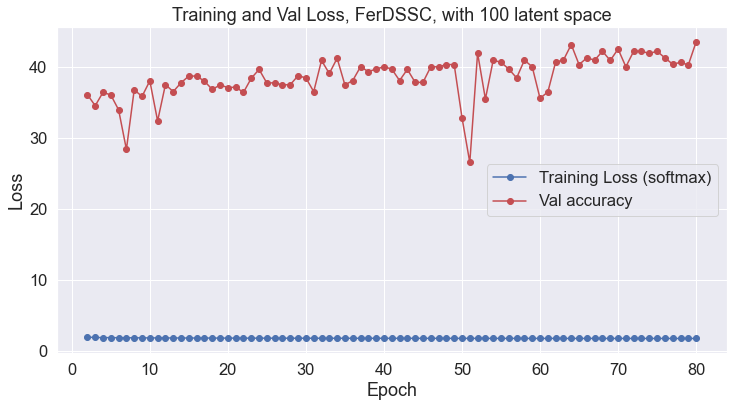

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
def plot_loss_vals(loss_vals, lv2, title="Training loss", start_idx=1):
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    plt.plot([i + start_idx for i in range(len(loss_vals[start_idx - 1:]))], loss_vals[start_idx - 1:], 'b-o', label="Training Loss (softmax)")
    plt.plot([i + start_idx for i in range(len(lv2[start_idx - 1:]))], lv2[start_idx - 1:], 'r-o', label="Val accuracy")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
plot_loss_vals(trainingLosses, valLosses, title="Training and Val Loss, FerDSSC, with 100 latent space", start_idx=2)

In [16]:
# evaluate test accuracy

class_correct = list(0. for i in range(len(id2idx)))
class_total = list(0. for i in range(len(id2idx)))
with torch.no_grad():
    for data in testLoader:
        inputs, labels = data["image"].to(device), data["label"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


In [17]:
for i in range(len(idx2id)):
    print('Accuracy of %5s : %2d %%' % (
        idx2id[i], 100 * class_correct[i] / class_total[i]))

Accuracy of  NONE : 60 %
Accuracy of    Ni :  0 %
Accuracy of    Mn : 44 %
Accuracy of    Ag : 25 %
Accuracy of    Pb : 22 %
Accuracy of    Cu : 14 %
Accuracy of    Fe : 54 %
Accuracy of     U :  0 %
Accuracy of    Au : 73 %
